In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import csv
from datetime import datetime
import re
from twython import Twython
from twython import TwythonStreamer
import pandas as pd
from collections import Counter
from nltk.corpus import stopwords
import string
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sbuciuma/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
APP_KEY = "LUpqT9BUMzTzdDFVYMls5myJe"
APP_SECRET = "EP31NVKfAg1kWnE3CA0FRRARJMX07irWX9VQUNyUU2pnFPlBeg"
twitter = Twython(APP_KEY, APP_SECRET)

In [3]:
for i in range(0, 17):
    user_timeline = twitter.get_user_timeline(screen_name="realDonaldTrump",count=1000, include_rts=False)

In [4]:
#lis=user_timeline[0]['id']-1 #tweet id # for most recent tweet
#only query as deep as necessary
#tweetsum= user_timeline[0]['user']['statuses_count']
#cycles=ceil(tweetsum / 200)
#if cycles>16:
    #cycles=16 #API only allows depth of 3200 so no point trying deeper than 200*16
#time.sleep(60)
#for i in range(0, cycles): ## iterate through all tweets up to max of 3200
    #incremental = twitter.get_user_timeline(screen_name=handle,
    #count=200, include_retweets=True, max_id=lis)
    #user_timeline.extend(incremental)
    #lis=user_timeline[-1]['id']-1
    #time.sleep(90) ## 90 second rest between api calls. The API allows 15 calls per 15 minutes so this is conservative


In [5]:
for i, val in enumerate(user_timeline):
    user_timeline[i]['user_screen_name']=user_timeline[i]['user']['screen_name']
    user_timeline[i]['user_followers_count']=user_timeline[i]['user']['followers_count']
    user_timeline[i]['user_id']=user_timeline[i]['user']['id']
    user_timeline[i]['user_created_at']=user_timeline[i]['user']['created_at']
    if 'retweeted_status' in user_timeline[i].keys():
        user_timeline[i]['rt_count'] = user_timeline[i]['retweeted_status']['retweet_count']
        user_timeline[i]['qt_id'] = user_timeline[i]['retweeted_status']['id']
        user_timeline[i]['rt_created'] = user_timeline[i]['retweeted_status']['created_at']
        user_timeline[i]['rt_user_screenname'] = user_timeline[i]['retweeted_status']['user']['name']
        user_timeline[i]['rt_user_id'] = user_timeline[i]['retweeted_status']['user']['id']
        user_timeline[i]['rt_user_followers'] = user_timeline[i]['retweeted_status']['user']['followers_count']
        del user_timeline[i]['retweeted_status']
    if 'quoted_status' in user_timeline[i].keys():
        user_timeline[i]['qt_created'] = user_timeline[i]['quoted_status']['created_at']
        user_timeline[i]['qt_id'] = user_timeline[i]['quoted_status']['id']
        user_timeline[i]['qt_text'] = user_timeline[i]['quoted_status']['text']
        user_timeline[i]['qt_user_screenname'] = user_timeline[i]['quoted_status']['user']['name']
        user_timeline[i]['qt_user_id'] = user_timeline[i]['quoted_status']['user']['id']
        user_timeline[i]['qt_user_followers'] = user_timeline[i]['quoted_status']['user']['followers_count']
        del user_timeline[i]['quoted_status']
    if user_timeline[i]['entities']['urls']: #list
        for j, val in enumerate(user_timeline[i]['entities']['urls']):
            urlj='url_'+str(j)
            user_timeline[i][urlj]=user_timeline[i]['entities']['urls'][j]['expanded_url']
    if user_timeline[i]['entities']['user_mentions']: #list
        for j, val in enumerate(user_timeline[i]['entities']['user_mentions']):
            mentionj='mention_'+str(j)
            user_timeline[i][mentionj] = user_timeline[i]['entities']['user_mentions'][j]['screen_name']
    if user_timeline[i]['entities']['hashtags']: #list
        for j, val in enumerate(user_timeline[i]['entities']['hashtags']):
            hashtagj='hashtag_'+str(j)
            user_timeline[i][hashtagj] = user_timeline[i]['entities']['hashtags'][j]['text']
    if user_timeline[i]['coordinates'] is not None:  #NoneType or Dict
        user_timeline[i]['coord_long'] = user_timeline[i]['coordinates']['coordinates'][0]
        user_timeline[i]['coord_lat'] = user_timeline[i]['coordinates']['coordinates'][1]
    del user_timeline[i]['coordinates']
    del user_timeline[i]['user']
    del user_timeline[i]['entities']
    if 'place' in user_timeline[i].keys():  #NoneType or Dict
        del user_timeline[i]['place']
    if 'extended_entities' in user_timeline[i].keys():
        del user_timeline[i]['extended_entities']
    if 'geo' in user_timeline[i].keys():
        del user_timeline[i]['geo']

In [6]:
today = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(today)

2016-09-27 17:44:16


In [7]:
trumpdf = pd.DataFrame(user_timeline)
#print(dftrump) original dataframe 

In [8]:
today = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(today)
#dftrump['test'] = pd.Series([today for x in range(len(dftrump.index))], index=dftrump.index)

2016-09-27 17:44:16


In [9]:
#initial creation of dataframe
#trumpdf = pd.DataFrame(user_timeline)
#convert created date in datetime format
trumpdf['created_at'] = pd.to_datetime(trumpdf['created_at'])

In [10]:
trumpdf.head()

,contributors,coord_lat,coord_long,created_at,favorite_count,favorited,hashtag_0,hashtag_1,hashtag_2,hashtag_3,...,retweeted,source,text,truncated,url_0,url_1,user_created_at,user_followers_count,user_id,user_screen_name
0,None,NaN,NaN,2016-09-27 21:08:22,4709,False,NaN,NaN,NaN,NaN,...,False,"<a href=""http://twitter.com/download/iphone"" r...","Once again, we will have a government of, by a...",False,http://bit.ly/2dxrgjaMOVEMENT,NaN,Wed Mar 18 13:46:38 +0000 2009,11846272,25073877,realDonaldTrump
1,None,NaN,NaN,2016-09-27 20:14:33,6320,False,NaN,NaN,NaN,NaN,...,False,"<a href=""http://twitter.com/download/iphone"" r...",Hillary Clinton's Campaign Continues To Make F...,False,http://bit.ly/2d4cDe8,NaN,Wed Mar 18 13:46:38 +0000 2009,11846272,25073877,realDonaldTrump
2,None,NaN,NaN,2016-09-27 20:06:25,7171,False,MAGA,NaN,NaN,NaN,...,False,"<a href=""http://twitter.com/download/iphone"" r...","'CNBC, Time magazine online polls say Donald T...",False,http://m.washingtontimes.com/news/2016/sep/27/...,NaN,Wed Mar 18 13:46:38 +0000 2009,11846272,25073877,realDonaldTrump
3,None,NaN,NaN,2016-09-27 19:59:04,9019,False,ImWithYou,NaN,NaN,NaN,...,False,"<a href=""http://twitter.com/download/iphone"" r...",Great afternoon in Little Havana with Hispanic...,False,NaN,NaN,Wed Mar 18 13:46:38 +0000 2009,11846272,25073877,realDonaldTrump
4,None,NaN,NaN,2016-09-27 19:37:22,15602,False,MAGA,NaN,NaN,NaN,...,False,"<a href=""http://twitter.com/download/iphone"" r...",In the last 24 hrs. we have raised over $13M f...,False,NaN,NaN,Wed Mar 18 13:46:38 +0000 2009,11846272,25073877,realDonaldTrump


In [11]:
list(trumpdf.columns.values)

['contributors',
 'coord_lat',
 'coord_long',
 'created_at',
 'favorite_count',
 'favorited',
 'hashtag_0',
 'hashtag_1',
 'hashtag_2',
 'hashtag_3',
 'id',
 'id_str',
 'in_reply_to_screen_name',
 'in_reply_to_status_id',
 'in_reply_to_status_id_str',
 'in_reply_to_user_id',
 'in_reply_to_user_id_str',
 'is_quote_status',
 'lang',
 'mention_0',
 'mention_1',
 'mention_2',
 'mention_3',
 'mention_4',
 'possibly_sensitive',
 'qt_created',
 'qt_id',
 'qt_text',
 'qt_user_followers',
 'qt_user_id',
 'qt_user_screenname',
 'quoted_status_id',
 'quoted_status_id_str',
 'retweet_count',
 'retweeted',
 'source',
 'text',
 'truncated',
 'url_0',
 'url_1',
 'user_created_at',
 'user_followers_count',
 'user_id',
 'user_screen_name']

In [12]:
#get structure of dataframe: row & col

trumpdf.shape

(180, 44)

In [13]:
for i in range(0, 7):
    temp_timeline = twitter.get_user_timeline(screen_name="realDonaldTrump",count=1000, include_rts=False)

In [14]:
for i, val in enumerate(temp_timeline):
    temp_timeline[i]['current_time'] = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    temp_timeline[i]['user_screen_name']=temp_timeline[i]['user']['screen_name']
    temp_timeline[i]['user_followers_count']=temp_timeline[i]['user']['followers_count']
    if 'retweeted_status' in temp_timeline[i].keys():
        temp_timeline[i]['rt_count'] = temp_timeline[i]['retweeted_status']['retweet_count']
        temp_timeline[i]['rt_created'] = temp_timeline[i]['retweeted_status']['created_at']
        temp_timeline[i]['rt_user_id'] = temp_timeline[i]['retweeted_status']['user']['id']
        temp_timeline[i]['rt_user_followers'] = temp_timeline[i]['retweeted_status']['user']['followers_count']
        del temp_timeline[i]['retweeted_status']     

In [15]:
df3 = pd.DataFrame(temp_timeline)
df3['created_at'] = pd.to_datetime(df3['created_at'])

In [16]:
df3.shape

(180, 31)

In [17]:
df3.head()

,contributors,coordinates,created_at,current_time,entities,extended_entities,favorite_count,favorited,geo,id,...,quoted_status_id,quoted_status_id_str,retweet_count,retweeted,source,text,truncated,user,user_followers_count,user_screen_name
0,None,None,2016-09-27 21:08:22,2016-09-27 17:44:20,{'media': [{'display_url': 'pic.twitter.com/uY...,{'media': [{'display_url': 'pic.twitter.com/uY...,4711,False,None,780876760086880256,...,NaN,NaN,1744,False,"<a href=""http://twitter.com/download/iphone"" r...","Once again, we will have a government of, by a...",False,"{'url': 'https://t.co/mZB2hymxC9', 'created_at...",11846272,realDonaldTrump
1,None,None,2016-09-27 20:14:33,2016-09-27 17:44:20,"{'user_mentions': [], 'urls': [{'display_url':...",NaN,6325,False,None,780863218646474757,...,NaN,NaN,2408,False,"<a href=""http://twitter.com/download/iphone"" r...",Hillary Clinton's Campaign Continues To Make F...,False,"{'url': 'https://t.co/mZB2hymxC9', 'created_at...",11846272,realDonaldTrump
2,None,None,2016-09-27 20:06:25,2016-09-27 17:44:20,{'user_mentions': [{'screen_name': 'WashTimes'...,NaN,7174,False,None,780861171238834176,...,NaN,NaN,2701,False,"<a href=""http://twitter.com/download/iphone"" r...","'CNBC, Time magazine online polls say Donald T...",False,"{'url': 'https://t.co/mZB2hymxC9', 'created_at...",11846272,realDonaldTrump
3,None,None,2016-09-27 19:59:04,2016-09-27 17:44:20,{'media': [{'display_url': 'pic.twitter.com/vx...,{'media': [{'display_url': 'pic.twitter.com/vx...,9022,False,None,780859319319400448,...,NaN,NaN,3072,False,"<a href=""http://twitter.com/download/iphone"" r...",Great afternoon in Little Havana with Hispanic...,False,"{'url': 'https://t.co/mZB2hymxC9', 'created_at...",11846272,realDonaldTrump
4,None,None,2016-09-27 19:37:22,2016-09-27 17:44:20,"{'user_mentions': [], 'urls': [], 'hashtags': ...",NaN,15606,False,None,780853860135006211,...,NaN,NaN,4610,False,"<a href=""http://twitter.com/download/iphone"" r...",In the last 24 hrs. we have raised over $13M f...,False,"{'url': 'https://t.co/mZB2hymxC9', 'created_at...",11846272,realDonaldTrump


In [18]:
list(df3.columns.values)

['contributors',
 'coordinates',
 'created_at',
 'current_time',
 'entities',
 'extended_entities',
 'favorite_count',
 'favorited',
 'geo',
 'id',
 'id_str',
 'in_reply_to_screen_name',
 'in_reply_to_status_id',
 'in_reply_to_status_id_str',
 'in_reply_to_user_id',
 'in_reply_to_user_id_str',
 'is_quote_status',
 'lang',
 'place',
 'possibly_sensitive',
 'quoted_status',
 'quoted_status_id',
 'quoted_status_id_str',
 'retweet_count',
 'retweeted',
 'source',
 'text',
 'truncated',
 'user',
 'user_followers_count',
 'user_screen_name']

In [19]:
#create create dataframe with the required fields for analysis.
#trumpdf is the primary/original tweeter request, we create the df1
df1 = trumpdf[['created_at','favorite_count','id', 'lang', 'retweet_count', 'user_followers_count','user_screen_name', 'text']]

In [20]:
df1.shape

(180, 8)

In [21]:
#get the index/column list 
list(df1.columns.values)

['created_at',
 'favorite_count',
 'id',
 'lang',
 'retweet_count',
 'user_followers_count',
 'user_screen_name',
 'text']

In [22]:
#create second dataframe witht he required fields for join and create the realDonaldTrump, here is the df3 
#so we create df2

df2 = df3[['current_time','favorite_count','id', 'retweet_count', 'user_followers_count','user_screen_name']]

In [23]:
list(df2.columns.values)

['current_time',
 'favorite_count',
 'id',
 'retweet_count',
 'user_followers_count',
 'user_screen_name']

In [24]:
df2.shape

(180, 6)

In [25]:
realDonaldTrump = pd.merge(df1, df2, how='inner', on=['id', 'user_screen_name'], left_index=True, sort=True, copy=True, )

In [26]:
#create final dataframe with required fields for analysis. using inner join in order to find the one already in the dataframe.
#realDonaldTrump = pd.merge(df1, df2, how='inner', on=['key1', 'key2'])

In [27]:
realDonaldTrump.head()

,created_at,favorite_count_x,id,lang,retweet_count_x,user_followers_count_x,user_screen_name,text,current_time,favorite_count_y,retweet_count_y,user_followers_count_y
179,2016-09-08 10:52:27,22329,773836389943246848,en,5212,11846272,realDonaldTrump,"Wow, reviews are in - THANK YOU!",2016-09-27 17:44:20,22329,5212,11846272
178,2016-09-08 12:10:13,29963,773855962528620548,en,8940,11846272,realDonaldTrump,"""A rough night for Hillary Clinton"" ABC News.",2016-09-27 17:44:20,29963,8940,11846272
177,2016-09-08 15:17:47,35996,773903163296473088,en,11264,11846272,realDonaldTrump,Hillary just gave a disastrous news conference...,2016-09-27 17:44:20,35996,11264,11846272
176,2016-09-08 16:25:36,31254,773920230192054272,en,10677,11846272,realDonaldTrump,Hillary Clinton answered email questions diffe...,2016-09-27 17:44:20,31254,10677,11846272
175,2016-09-08 18:16:25,17621,773948120069615616,en,4896,11846272,realDonaldTrump,Mexico has lost a brilliant finance minister a...,2016-09-27 17:44:20,17621,4896,11846272


In [28]:
#d = dict(screen_name = screen_name, Favorites = favorites_count, Retweets = retweets_count,Date = date, Text = text)

#HillaryClinton = pd.DataFrame({k : pd.Series(v) for k, v in  list(d.items())})
status_texts = realDonaldTrump[['text']]
print(status_texts)

                                                  text
179                   Wow, reviews are in - THANK YOU!
178     "A rough night for Hillary Clinton"  ABC News.
177  Hillary just gave a disastrous news conference...
176  Hillary Clinton answered email questions diffe...
175  Mexico has lost a brilliant finance minister a...
174  With Luis, Mexico and the United States would ...
173  Last nights results - in poll taken by NBC. #A...
172  More poll results from last nights Commander-i...
171  It wasn't Matt Lauer that hurt Hillary last ni...
170  Final poll results from NBC on last nights Com...
169  The documentary of me that @CNN just aired is ...
168  .@CNN is unwatchable. Their news on me is fict...
167  Jeff Zucker failed @NBC and he is now failing ...
166  Henry McMaster, Lt. Governor of South Carolina...
165  MAKE AMERICA GREAT AGAIN!\n#AmericaFirst #ImWi...
164  Great honor to be endorsed by popular &amp; su...
163  Thank you Ohio. Together, we will MAKE AMERICA...
162  Will 

In [29]:
#count words in each tweet, we can also lower all the words/characters to by using .lower(),
words_trump = pd.Series(' '.join(realDonaldTrump.text).split())
punctuation = list(string.punctuation)
stop = stopwords.words('english') + punctuation + ['rt', 'via']

In [30]:

#implementation of stop words using nltk library for language processing
terms_stop = [term for term in words_trump if term not in stop]

In [31]:
print(terms_stop)

['Wow,', 'reviews', 'THANK', 'YOU!', '"A', 'rough', 'night', 'Hillary', 'Clinton"', 'ABC', 'News.', 'Hillary', 'gave', 'disastrous', 'news', 'conference', 'tarmac', 'make', 'poor', 'performance', 'last', 'night.', "She's", 'decimated', 'media!', 'Hillary', 'Clinton', 'answered', 'email', 'questions', 'differently', 'last', 'night', 'past.', 'She', 'totally', 'confused.', 'Unfit', 'serve', '#POTUS.', 'Mexico', 'lost', 'brilliant', 'finance', 'minister', 'wonderful', 'man', 'I', 'know', 'highly', 'respected', 'President', 'Peña', 'Nieto.', 'With', 'Luis,', 'Mexico', 'United', 'States', 'would', 'made', 'wonderful', 'deals', 'together', 'Mexico', 'US', 'would', 'benefitted.', 'Last', 'nights', 'results', 'poll', 'taken', 'NBC.', '#AmericaFirst', '#ImWithYou', 'https://t.co/sCOnny1fl3', 'More', 'poll', 'results', 'last', 'nights', 'Commander-in-Chief', 'Forum.', '#AmericaFirst', '#TrumpTrain', 'https://t.co/FxyBL6fO1h', 'It', "wasn't", 'Matt', 'Lauer', 'hurt', 'Hillary', 'last', 'night.', 

In [32]:
word_counts = {}
for word in terms_stop:
    if word in word_counts:
        word_counts[word] += 1
    else:
        word_counts[word] = 1

In [33]:
print(word_counts)

{'truly': 3, 'needs': 1, 'U.S.': 2, 'https://t.co/PGimqYKPoJ': 1, 'it,': 1, 'amazing,': 1, 'tune': 1, 'wealth': 2, 'https://t.co/yIeZctdQy8': 1, 'Civic': 1, 'taken': 2, 'driving': 2, 'feel': 1, 'immediate': 1, 'estates': 1, 'winning.': 1, 'true!': 1, 'MAKE': 10, '@WSJ:': 1, "Tomorrow's": 1, 'enforcement': 1, 'years': 4, 'Secret': 1, '❌RUSSIAN': 1, 'calls': 2, 'knows': 4, '@TerryBranstad!': 1, 'differently': 1, 'Wow,': 3, '@tonyschwartz,': 1, 'movement.': 1, '6pm!': 2, 'moment.': 1, 'https://t.co/CIJMQJhLqp': 1, 'Little': 1, 'NYC.': 1, 'need': 2, 'South': 1, 'national': 1, 'deplorables': 1, 'appreciate': 1, 'Their': 1, 'jail.': 1, 'system?': 1, 'Heading': 3, 'afternoon': 1, 'stage': 1, '@gov_gilmore': 1, 'want': 2, 'away,': 2, 'boring': 1, 'debate.': 2, 'tarmac': 1, 'Colin': 1, 'funeral': 1, 'rough': 1, 'nights': 4, 'managing': 1, 'totally': 1, 'Carolina': 4, 'fight': 2, 'State': 1, 'Center.': 1, 'you!': 14, '30': 4, 'receiving': 1, 'honored': 1, '#TheTonightShow': 1, 'in!': 1, 'Florida

In [34]:
#one more filtering with some custome specified stopwords what are not in nltk library
filterTump = {k: v for k, v in word_counts.items() if v > 1}

print(filterTump)

Stopwords = ['A','AND','An','And','As','Be','C','this','they',
'Can','D','Do','Don','For','Go','He','IS','Is','It','K','M', 'I',
'O','On','P','Q','R','S','So','T','THE','That','The','Their','There',
'They','This','U','we','you','words','w','ve','u','the','that','than',
'her','he','had','for','e','d','co','a','V','TV','was','to','so','she'
't','such','some','s','re','my','m','ll','is','it','of','as','at','am',
't', 'or','our','in','do','be','them','they','their','this','were','when',
'who','with','what','amp','an','and','are','000','your','she','him','his',
'get','but','would','https','on','realDonaldTrump','have','will','all','has',
'just', 'MakeAmericaGreatAgain','now','out','about','from','by', 'the', 'v', 'b','—Hillary','&amp;']

for k, v in list(filterTump.items()):
    print(k, v)
    if k in Stopwords:
        del filterTump[k]

{'truly': 3, 'A': 6, 'people.': 3, 'Lets': 2, 'now.': 2, 'wealth': 2, 'See': 2, 'police': 2, 'taken': 2, 'driving': 2, 'Iraq': 2, 'Dem': 2, 'including': 2, '#ImWithYou…': 2, 'MAKE': 10, 'years': 4, 'WILL': 2, 'Just': 6, 'years.': 2, 'calls': 2, 'knows': 4, 'States': 2, 'Bernie': 2, '@seanhannity': 2, 'us:': 2, 'Wow,': 3, 'votes.': 2, 'campaign.': 2, 'today': 5, 'The': 12, 'About': 2, 'Russia': 2, 'need': 2, "don't": 3, 'them.': 2, 'getting': 2, 'last': 12, 'support!': 2, 'put': 2, 'big': 3, 'Enjoy!': 9, 'Heading': 3, 'Great': 9, 'We': 9, 'Virginia': 4, 'want': 2, 'away,': 2, 'noon!': 2, '#DebateNight': 9, 'Time': 2, 'It': 6, '@foxandfriends': 7, 'would': 6, 'people': 4, 'Debate': 2, "'How": 2, 'They': 2, 'nights': 4, 'magnet': 2, 'Carolina': 4, 'debate': 4, 'failed': 4, 'Secretary': 2, 'SAFE': 3, "Hillary's": 2, '#MakeAmericaGreatAgain': 4, 'Twitter': 2, 'got': 2, 'speech': 2, '#MAGA…': 2, 'done': 2, 'victory': 2, '#Debates2016': 8, '#MAGA': 17, '.@CNN': 2, 'National': 3, 'said': 8, 'l

In [35]:
toptwentyTrump = dict(Counter(filterTump).most_common(20))
print(toptwentyTrump)


{'Clinton': 16, 'last': 12, '#Debates2016': 8, '#MAGA': 17, 'Enjoy!': 9, 'Will': 11, '#AmericaFirst': 16, 'Join': 14, 'Hillary': 24, 'said': 8, 'Great': 9, 'you!': 14, 'We': 9, 'Thank': 37, 'AMERICA': 12, 'Trump': 10, '#DebateNight': 9, 'GREAT': 8, 'MAKE': 10, 'poll': 11}


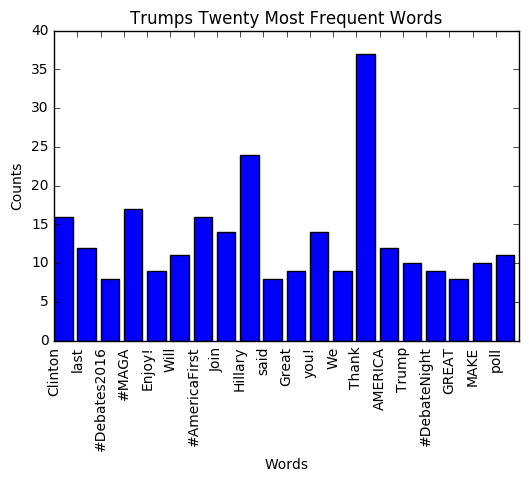

In [36]:
plt.bar(range(len(toptwentyTrump)), toptwentyTrump.values(), align='edge')
plt.xticks(range(len(toptwentyTrump)), toptwentyTrump.keys(), rotation=90)
plt.title('Trumps Twenty Most Frequent Words')
plt.xlabel('Words')
plt.ylabel('Counts')

In [37]:
#counting words
from collections import Counter
counts = Counter(word_counts)
print(counts)

Counter({'Thank': 37, 'I': 35, 'Hillary': 24, '#MAGA': 17, '#AmericaFirst': 16, 'Clinton': 16, '&amp;': 16, 'Join': 14, 'you!': 14, 'last': 12, 'AMERICA': 12, 'The': 12, 'Will': 11, 'poll': 11, 'MAKE': 10, 'Trump': 10, '#DebateNight': 9, 'Enjoy!': 9, 'Great': 9, 'We': 9, '#ImWithYou': 8, '#Debates2016': 8, 'said': 8, 'GREAT': 8, 'great': 8, 'MOVEMENT': 7, 'us': 7, '@foxandfriends': 7, 'many': 6, 'failing': 6, 'would': 6, 'AGAIN!': 6, 'It': 6, 'Obama': 6, 'never': 6, 'A': 6, 'Just': 6, 'interviewed': 6, 'job': 5, '@CNN': 5, 'Together,': 5, 'https://t.co/3KWOl2ibaW': 5, 'thank': 5, 'today': 5, 'Crooked': 5, 'polls': 5, 'wonderful': 5, 'get': 5, 'North': 5, 'knows': 4, 'nights': 4, 'Carolina': 4, 'Presidential': 4, '#MakeAmericaGreatAgain': 4, 'going': 4, 'Virginia': 4, 'My': 4, 'soon.': 4, 'people': 4, 'much': 4, 'A.M.': 4, 'debate': 4, 'years': 4, 'make': 4, 'Governor': 4, 'To': 4, 'results': 4, '30': 4, '@realDonaldTrump': 4, 'failed': 4, 'new': 4, 'back': 4, '.@HillaryClinton': 4, 'li

In [38]:
a = Counter(filterTump).most_common(20)
print (a)

[('Thank', 37), ('Hillary', 24), ('#MAGA', 17), ('Clinton', 16), ('#AmericaFirst', 16), ('Join', 14), ('you!', 14), ('last', 12), ('AMERICA', 12), ('poll', 11), ('Will', 11), ('MAKE', 10), ('Trump', 10), ('Enjoy!', 9), ('Great', 9), ('We', 9), ('#DebateNight', 9), ('#Debates2016', 8), ('said', 8), ('GREAT', 8)]


In [39]:
from prettytable import PrettyTable
sorted(a)
pt = PrettyTable(field_names=['word', 'Frequency_Trump'])
[ pt.add_row(row) for row in sorted(a, reverse=True)[:20] ]
pt.max_width['Text'] = 50
pt.align= 'l'
print (pt)

+---------------+-----------------+
| word          | Frequency_Trump |
+---------------+-----------------+
| you!          | 14              |
| said          | 8               |
| poll          | 11              |
| last          | 12              |
| Will          | 11              |
| We            | 9               |
| Trump         | 10              |
| Thank         | 37              |
| MAKE          | 10              |
| Join          | 14              |
| Hillary       | 24              |
| Great         | 9               |
| GREAT         | 8               |
| Enjoy!        | 9               |
| Clinton       | 16              |
| AMERICA       | 12              |
| #MAGA         | 17              |
| #Debates2016  | 8               |
| #DebateNight  | 9               |
| #AmericaFirst | 16              |
+---------------+-----------------+


In [40]:
#Although labels for each word are not provided, x-axis values have been sorted so that the relationship between word frequencies is more apparent.
#Each axis has been adjusted to a logarithmic scale to "squash" the curve being displayed

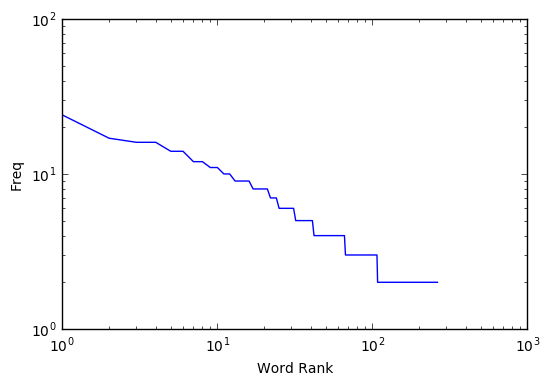

In [41]:
word_counts = sorted(Counter(filterTump).values(), reverse=True)

plt.loglog(word_counts)
plt.ylabel("Freq")
plt.xlabel("Word Rank")

[5212, 8940, 11264, 10677, 4896, 5009, 15839, 10512, 15285, 10734, 8269, 15768, 4535, 5184, 9976, 7791, 8581, 3591, 7012, 4429, 4370, 4781, 2447, 6057, 21985, 12131, 25876, 15751, 8028, 11792, 3146, 2364, 9305, 8088, 5246, 4208, 4181, 5259, 2892, 11028, 7170, 3757, 4058, 4147, 24975, 8088, 7730, 11665, 2716, 7294, 8147, 3930, 6225, 6649, 3031, 7876, 3481, 2117, 3693, 8659, 3380, 6013, 3668, 3981, 10618, 2513, 4409, 5823, 6628, 10379, 10122, 5774, 8559, 5220, 7092, 8437, 14569, 7436, 13049, 6163, 5503, 10119, 7996, 5738, 5800, 16268, 11882, 19661, 12650, 2152, 4584, 7734, 16410, 16141, 10464, 8018, 2819, 10575, 8262, 9373, 5815, 5986, 12389, 6507, 31039, 9571, 8128, 16396, 9643, 13399, 8864, 10434, 3240, 4585, 3925, 2283, 4446, 6204, 8303, 6198, 19779, 7056, 4523, 9331, 7002, 12653, 9991, 4763, 31651, 6420, 8565, 8485, 8529, 11544, 11271, 17033, 11446, 19778, 16380, 7792, 5012, 7082, 9629, 7807, 11621, 13209, 11963, 5728, 8904, 21433, 11677, 6627, 30601, 8502, 18124, 7232, 5518, 12579, 

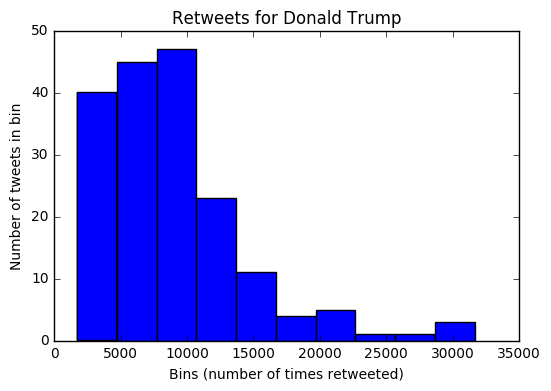

In [42]:
# Generating a histogram of retweet counts
#Using underscores while unpacking values in
# a tuple is idiomatic for discarding them
retweet = realDonaldTrump['retweet_count_x']

#print(retweet)
counts = [count for count in retweet]

plt.hist(counts)
plt.title("Retweets for Donald Trump")
plt.xlabel('Bins (number of times retweeted)')
plt.ylabel('Number of tweets in bin')

print (counts)

[5212, 8940, 11264, 10677, 4896, 5009, 15839, 10512, 15285, 10734, 8269, 15768, 4535, 5184, 9976, 7791, 8581, 3591, 7012, 4429, 4370, 4781, 2447, 6057, 21985, 12131, 25876, 15751, 8028, 11792, 3146, 2364, 9305, 8088, 5246, 4208, 4181, 5259, 2892, 11028, 7170, 3757, 4058, 4147, 24975, 8088, 7730, 11665, 2716, 7294, 8147, 3930, 6225, 6649, 3031, 7876, 3481, 2117, 3693, 8659, 3380, 6013, 3668, 3981, 10618, 2513, 4409, 5823, 6628, 10379, 10122, 5774, 8559, 5220, 7092, 8437, 14569, 7436, 13049, 6163, 5503, 10119, 7996, 5738, 5800, 16268, 11882, 19661, 12650, 2152, 4584, 7734, 16410, 16141, 10464, 8018, 2819, 10575, 8262, 9373, 5815, 5986, 12389, 6507, 31039, 9571, 8128, 16396, 9643, 13399, 8864, 10434, 3240, 4585, 3925, 2283, 4446, 6204, 8303, 6198, 19779, 7056, 4523, 9331, 7002, 12653, 9991, 4763, 31651, 6420, 8565, 8485, 8529, 11544, 11271, 17033, 11446, 19778, 16380, 7792, 5012, 7082, 9629, 7807, 11621, 13210, 11963, 5728, 8904, 21433, 11678, 6627, 30602, 8502, 18124, 7232, 5518, 12579, 

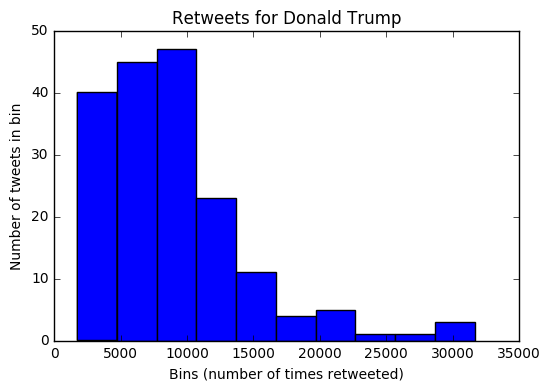

In [43]:
# Generating a histogram of retweet counts
#Using underscores while unpacking values in
# a tuple is idiomatic for discarding them
retweet = realDonaldTrump['retweet_count_y']

#print(retweet)
counts = [count for count in retweet]

plt.hist(counts)
plt.title("Retweets for Donald Trump")
plt.xlabel('Bins (number of times retweeted)')
plt.ylabel('Number of tweets in bin')

print (counts)

In [44]:
from nltk import FreqDist

freqdist = nltk.FreqDist(filterTump)

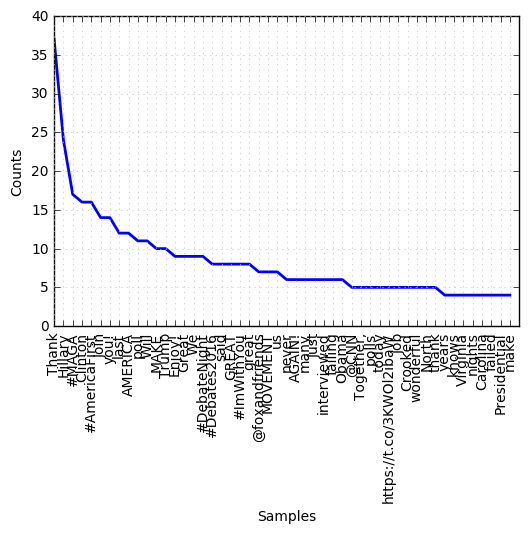

In [45]:
freqdist.plot(50)

In [46]:
flyers1m = realDonaldTrump[['created_at','retweet_count_x', 'current_time', 'retweet_count_y']]
flyers1m.head()

,created_at,retweet_count_x,current_time,retweet_count_y
179,2016-09-08 10:52:27,5212,2016-09-27 17:44:20,5212
178,2016-09-08 12:10:13,8940,2016-09-27 17:44:20,8940
177,2016-09-08 15:17:47,11264,2016-09-27 17:44:20,11264
176,2016-09-08 16:25:36,10677,2016-09-27 17:44:20,10677
175,2016-09-08 18:16:25,4896,2016-09-27 17:44:20,4896


In [47]:
#create difference in retweets

realDonaldTrump['retweet_cumulative'] = realDonaldTrump['retweet_count_x'] - realDonaldTrump['retweet_count_y']

In [48]:
realDonaldTrump.head()

,created_at,favorite_count_x,id,lang,retweet_count_x,user_followers_count_x,user_screen_name,text,current_time,favorite_count_y,retweet_count_y,user_followers_count_y,retweet_cumulative
179,2016-09-08 10:52:27,22329,773836389943246848,en,5212,11846272,realDonaldTrump,"Wow, reviews are in - THANK YOU!",2016-09-27 17:44:20,22329,5212,11846272,0
178,2016-09-08 12:10:13,29963,773855962528620548,en,8940,11846272,realDonaldTrump,"""A rough night for Hillary Clinton"" ABC News.",2016-09-27 17:44:20,29963,8940,11846272,0
177,2016-09-08 15:17:47,35996,773903163296473088,en,11264,11846272,realDonaldTrump,Hillary just gave a disastrous news conference...,2016-09-27 17:44:20,35996,11264,11846272,0
176,2016-09-08 16:25:36,31254,773920230192054272,en,10677,11846272,realDonaldTrump,Hillary Clinton answered email questions diffe...,2016-09-27 17:44:20,31254,10677,11846272,0
175,2016-09-08 18:16:25,17621,773948120069615616,en,4896,11846272,realDonaldTrump,Mexico has lost a brilliant finance minister a...,2016-09-27 17:44:20,17621,4896,11846272,0


In [54]:
tweets = realDonaldTrump['text']

In [49]:
avg = flyers1m.mean()

In [50]:
print(avg)

retweet_count_x    8932.794444
retweet_count_y    8932.883333
dtype: float64


In [51]:
flyers2m = realDonaldTrump[['created_at','retweet_count_x']]

In [52]:
import vincent
vincent.core.initialize_notebook()
area = vincent.Area(flyers2m)
area.colors(brew='Spectral')
area.display()

In [60]:
station_idx = realDonaldTrump['user_screen_name']
print(station_idx)

179    realDonaldTrump
178    realDonaldTrump
177    realDonaldTrump
176    realDonaldTrump
175    realDonaldTrump
174    realDonaldTrump
173    realDonaldTrump
172    realDonaldTrump
171    realDonaldTrump
170    realDonaldTrump
169    realDonaldTrump
168    realDonaldTrump
167    realDonaldTrump
166    realDonaldTrump
165    realDonaldTrump
164    realDonaldTrump
163    realDonaldTrump
162    realDonaldTrump
161    realDonaldTrump
160    realDonaldTrump
159    realDonaldTrump
158    realDonaldTrump
157    realDonaldTrump
156    realDonaldTrump
155    realDonaldTrump
154    realDonaldTrump
153    realDonaldTrump
152    realDonaldTrump
151    realDonaldTrump
150    realDonaldTrump
            ...       
29     realDonaldTrump
28     realDonaldTrump
27     realDonaldTrump
26     realDonaldTrump
25     realDonaldTrump
24     realDonaldTrump
23     realDonaldTrump
22     realDonaldTrump
21     realDonaldTrump
20     realDonaldTrump
19     realDonaldTrump
18     realDonaldTrump
17     real

In [61]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer(analyzer='word', ngram_range=(1,3), min_df = 0, stop_words = 'english')

In [62]:
tfidf_matrix =  tf.fit_transform(tweets)
feature_names = tf.get_feature_names() 

In [63]:
len(feature_names)

3666

In [64]:
feature_names[50:70]

['24',
 '24 hrs',
 '24 hrs raised',
 '27sr3mjjxc',
 '2nd',
 '2nd amendment',
 '2nd amendment rights',
 '2xbs5ssrc3',
 '30',
 '30 years',
 '30 years getting',
 '30 years policy',
 '30 years presidential',
 '35pme',
 '35pme tonight',
 '35pme tonight enjoy',
 '39',
 '39 americafirst',
 '39 americafirst imwithyou',
 '39fcnuf8pb']

In [65]:
tfidf_matrix

<180x3666 sparse matrix of type '<class 'numpy.float64'>'
	with 4780 stored elements in Compressed Sparse Row format>

In [67]:
dense = tfidf_matrix.todense()
len(dense[0].tolist()[0])

3666

In [68]:
episode = dense[0].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(episode)), episode) if pair[1] > 0]

In [69]:
len(phrase_scores)

6

In [70]:
sorted(phrase_scores, key=lambda t: t[1] * -1)[:5]

[(2660, 0.44933970304326726),
 (2661, 0.44933970304326726),
 (3613, 0.44933970304326726),
 (3614, 0.44933970304326726),
 (3608, 0.39276590542382084)]

In [71]:
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:20]:
   print('{0: <20} {1}'.format(phrase, score))

reviews              0.44933970304326726
reviews thank        0.44933970304326726
wow reviews          0.44933970304326726
wow reviews thank    0.44933970304326726
wow                  0.39276590542382084
thank                0.19521851503522866
